# Week 7: Segmentation

## 0. 前言

本实验是本实验为中山大学数据科学与计算机技术课程，实验课第六周的实验安排和内容。请各位同学按照本实验指导书的引导和独立完成实验内容。

在实验的过程中，有任何**不解的内容（代码）或者发现了实验设置部分的Bug**，非常欢迎您能够__`截图保存`__下来发送到邮箱  <cuizhiying.csu@gmail.com> （崔志颖）中，我会尽快给予回复和修正。您的反馈，是对我们最大的鼓励！

### 0.1 实验内容和要求

1. 体验语义分割网络的运行过程，和基本的代码结构，结合理论课的内容，加深对语义分割模型的思考和理解
2. 独立完成实验指导书中提出的问题（简要回答）
3. 按照实验指导书的引导，填充缺失部分的代码，让程序顺利地运转起来
4. 代码量比较大，但是要**坚持独立完成，禁止抄袭**
5. 实验结束后，将整个文件夹下载下来（注意保留程序运行结果），打包上传到超算课堂网站中。

>
> 在命令行中使用自带的压缩工具tar压缩和解压的命令如下所示，第一条是压缩命令，第二条是解压命令，在此不展开解释
```
$ tar -zvcf week-06.tar.gz week-06
$ tar -zvxf week-06.tar.gz   
```

### 0.2 知识预备 

- 熟悉`Jupyter`交互环境的使用方式，及其与脚本的区别
- 熟悉基本的和经典的分类网络，如`vgg 16`， `vgg 19`等
- 了解分割网络的基本结构及其含义，如`skip`结构，`deconvolution`结构
- 结果的评估计算方式，如`Dice score`，`Jaccard score`，`cross entroy`计算

### 0.3 实验思路和流程

1. 本次实验过程中，先理解语义分割模型的数据的标签`Ground truth`的特点，体会其与分类网络的区别
2. 探索和训练一个简单的`UNet`网络（重点）
3. 在基础的网络结构之上，增加和修改的部分结构，进一步提升网络性能
4. 最后补充了反卷积的计算过程，这与前面卷积的计算过程相呼应

## 1. 数据准备和探索

首先，配置好我们需要的环境，因为代码比较多，所以我们将会以`Python Package`的形式给你提供大部分的代码。但是如果是普通的更新package的代码的话，需要对每一次更新都进行手动加载，比较麻烦。所幸`jupyter`为我们提供了自动加载的魔术方法，请执行以下代码，设置Python包在Jupyter环境下的自动更新问题。我们每一次对`import`的`package`进行修改的时候，修改的内容都会自动更新到这个环境中。

In [1]:
# This two line are jupyter magical method which use to auto reload the package you changed
%load_ext autoreload
%autoreload 2

由于`Pytorch`版本更替的原因，在比较新的Pytorch版本环境中运营该代码可能会产生一些弃用某些函数的warming，在此我们不必要关注这部分的信息，可以将其屏蔽掉：

In [2]:
import warnings
warnings.filterwarnings('ignore')

引入必要的通用的`Python`包，设置Jupyter的交互环境，为接下来的实验做准备，在执行新的代码之前。请运行下面代码（表面上无事发生，内心已有所不同）

In [3]:
# import necessary package for the following exercises
from __future__ import division, print_function
#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

### 1.1 数据集的产生

从`image_utils`文件夹中引入数据生成器。我们不太需要理解数据生成的过程，只需要观察生成好的图片数据即可。观察和分析数据集通常是我们的第一步，通过观察数据集的特点，可以进一步决定我们训练数据所需要选择的模型和训练的方式。请依次执行一下部分的代码：

In [4]:
# get the image generator
from image_utils import image_gen

通过导入的`image_gen`，构造一个带分割标签（`Ground truth`）的、超级精确的图片生成器。其中，变量`nx`和`ny`分别表示所生成的图片的长和宽，通过这两个参数，可以控制生成器生成图片的大小，一般要求是生成2的N次方(否则容易发生bug，具体原因在于在`downsample`的时候，产生小数被抹除，导致在`upsample`的过程中不能准确恢复抹除的小数部分)，`cnt`表示的是前景部分的需要分割出来的物体的个数,`sigma`表示添加噪音的强烈程度，sigma越小，噪音越弱，训练越简单，在下面的练习中可以看到。请执行以下部分代码（可根据自己的需求修改以上三个参数）：

In [5]:
# You can change the nx and ny to change the image size
nx  = 128
ny  = 128
cnt = 10
# sigma param is used to control the noise strength
generator = image_gen.GrayScaleDataProvider(nx, ny, cnt=cnt, sigma=20)
#generator = image_gen.RgbDataProvider(nx, ny）

#### Note 1
由于分割网络的代码参数量比较大，为了尽量降低实验过程对电脑设备和`GPU`显存大小的要求，在本次本次实验过程中，我们并没有使用语义分割最常用的数据集如`VOC`， `CoCo`等多分类语义分割数据集。而是选择了我们人工构造的几何形状作为数据集。这个数据集我们可以通过手动调节参数的方式，任意指定训练输入图片的大小，可以轻易得手动降低实验数据的数据量和对电脑内存（显存）资源的要求。这样子的__好处__在于在没有GPU资源的个人PC中，我们也可以训练好整个网络，让大家对语义分割模型有直观地感受。__不好的地方__在于这个数据集非常简单，很多的`Tricks`和模型的改进对性能的提升在这里可能体现得不明显。

### 1.2 观察数据集

我们在训练数据之前必须要对其进行充分的观察和分析，了解这个数据集的具体内容和相应的特点，清楚其难点在哪里，哪些部分的数据很具有挑战性，这些都可以增强我们对这个任务的直观的、感性的认识。

所以，现在我们现在可以来探索一下`generator`在做了些什么，为我们提供了怎么样的数据。查看生成数据的维度是一个非常直观且重要的观察方式，在我们自己编写模型的时候，模型`input`的维度要和`generator`的，请执行以下代码：

In [6]:
# 2 mean how many image you want to get
x_test, y_test = generator(2)
print(x_test.shape)
print(y_test.shape)

(2, 128, 128, 1)
(2, 128, 128, 2)


**************************************************************************
####  &#9733;&#9733;&#9733; Question 1 :
从上面的输出可以看出，这里面得到的数据格式是`B*H*W*C`，还是`B*C*H*W`？是否可以看出得到的图片是灰度图像还是RGB图像？为什么？   
【tips】B = batchsize, C = channel, H = height, W = width. 此前的课件中，`dataloader`函数中已经给大家安排好了输入数据的维度的问题，Pytorch为代表的框架使用`B×C×H×W`的形式，Tensorflow为代表的框架是用`B×H×W×C`的形式。在实际的网络训练过程中，我们需要自己处理好输入数据的维度的问题。这在接下来的代码中也有体现。

#### Answer 

`B*H*W*C`

`x_test` is gray scale; `y_test` is RGB, with only 2 channels. 

**************************************************************************

将数据可视化成图片显示出来，看看人类视觉的效果，请执行以下代码：

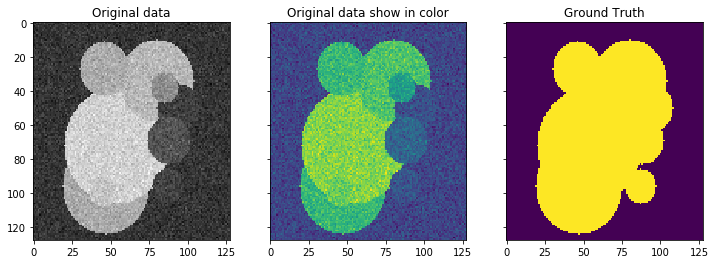

In [7]:
x_test, y_test = generator(2)
fig, ax = plt.subplots(1,3, sharey=True, figsize=(12,4))
ax[0].set_title("Original data")
ax[1].set_title("Original data show in color")
ax[2].set_title("Ground Truth")
ax[0].imshow(x_test[0,...,0], aspect="auto",  cmap="gray" )
ax[1].imshow(x_test[0,...,0], aspect="auto")
ax[2].imshow(y_test[0,...,1], aspect="auto")
plt.show()

*上面共产生了三幅图像，其中第一幅显示的是数据的原图，第二幅图像是`matplotlib`在可视化灰度图像的时候，为了增加图像的对比度，默认将其转换成`RGB`图像输出，第三幅图像显示的是该图像对应的分割的标签，也就是Ground Truth。由此可见，该`generator`生成的图片是一对一对生成的，生成训练图像的同时，也生成了该图像的标签。*

## 2. 基本的语义分割模型--UNet

准备好训练的数据之后，我们就可以开始构建我们的训练模型了。首先先来回顾一下`UNet`的网络结构   
![u-net-architecture](resources/u-net-architecture.png)


 *Architecture (example for 32x32 pixels in the lowest resolution). Each blue box corresponds to a multi-channel feature map. The number of channels is denoted on top of the box. The x-y-size is provided at the lower left edge of the box. White boxes represent copied feature maps. The arrows denote the different operations.*


### 2.1 网络的搭建

网络搭建的过程的代码位于同文件夹中的`unet`文件夹下面。文件的路径为`./unet/unet_parts.py`和`./unet/unet_model.py`，直接点开该文件夹下的`Python`文件阅读代码，了解网络搭建的过程，以下所有文件的位置，均以上述相对路径的形式指明，不加赘述。

在搭建网络的时候，注意体会代码中分模块化搭建的过程。比如，注意观察上面的`UNet`网络结构，在特征提取部分（代码`unet_part.py`中的`down`类）都是两次卷积加一次maxpool的过程；在细节恢复部分代码（代码`unet_part.py`中的`up`类）都是先级联上一次的特征图，然后再进行两次卷积。由于整个网络都是严格对称的，所以代码非常简单，可以很工整地使用模块化的编程思想，这有助于对这部分代码的理解。

### 2.2 训练网络

将网络模型导入到内存中。请执行以下代码：

In [8]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from unet import UNet
from unet import eval_net

检查设备中是否带有GPU，如果有的话，恭喜你，模型的训练速度是仅仅使用CPU进行训练无法企及的。该变量在接下来的实验中需要反复用到，来决定是使用CPU还是GPU。请执行以下代码：

In [9]:
is_cuda = True if torch.cuda.is_available() else False
print(is_cuda)

True


如果我们是在使用GPU的话，我们还可以通过以下代码来查看我们当前使用的设备, 当然了，没有GPU的时候执行以下代码就会报错，可以不必理会。

In [10]:
print( torch.cuda.current_device()  ) # which GPU you're using
print( torch.cuda.device_count()    ) # how many GPU you have
print( torch.cuda.get_device_name(0)) # device name

0
4
Tesla P100-SXM2-16GB


**自行手动更改当前使用的GPU的命令如下所示（学会这项技能学会自己指定空闲的GPU进行使用）：**

In [11]:
id = 3
torch.cuda.set_device(id)
print( torch.cuda.current_device() )

3


言归正传，我们需要新建一个网络的对象，定义loss函数和优化器，这里使用的是二分类的binary_cross_entropy，这与前面分类网络部分代码没有区别。请执行以下代码：

In [12]:
# Initialize a basic UNet
unet = UNet(n_channels=1, n_classes=2)
# Define a binary Corss entropy loss, the most common loss
criterion = nn.BCELoss()     
# Define a optimizer, specific way to update the parameters in your network
optimizer = optim.SGD( unet. parameters(),
                       lr           = 0.001,
                       momentum     = 0.9,
                       weight_decay = 0.0005
                     )

# whether you PC has a GPU? If yes, use it
if is_cuda:
    unet = unet.cuda()

至此，我们已经正式准备好了数据，网络结构，loss函数，以及参数更新所使用的优化器，万事具备，只欠训练了。

#### Note 2 
我们在这部分处理的代码，因为没有使用到真实的数据，仅仅是使用虚拟的数据而得到简化，具体体现在我们不需要进行繁琐的数据的取拿操作，不需要考虑经过多少个step之后得到一个epoch等问题，这不是我们本次实验需要关注的问题。但是我们在处理真实数据的时候，这些部分的内容需要我们去理解和管理。
在这里，我们只需要给这些参数填上一个差不多的数字即可，生成器即可按照我们的需要为我们提供我们所需要的数据。

下面代码中的`steps`变量代表的是每个epoch中网络迭代的次数，部分代码中也记作__`iterations`__，一个__`step`__，也就是一个__`iteration`__。__`batch_size`__指的是没有__`iteration`__中的__`minibach`__中图像的数量。请理解和执行以下部分代码。

In [13]:
epochs     = 5         # usual value is 50, 100, 150
steps      = 50        # usual value is ？ No usual value, just go through the whole training set
batch_size = 32         # usual value is 16， 32， 64, usually as big as possible
valid_size = 50        # No usual value, just 20% of the whole dataset

epoch_loss = 0

# use to plot the loss during training，counter is use to count the Number of iterations
curr_step  = np.zeros( epochs*steps )
step_loss  = np.zeros( epochs*steps )
counter    = 0
for epoch in range(epochs):
    for step in range(steps):
        batch_x, batch_y = generator(batch_size)
        
        # Remember the different between B*H*W*C (tensorflow) and B*C*H*W (pytorch, caffe)
        # we should change a batch of rgb images into correct index
        batch_x = np.transpose( batch_x, axes=[0, 3, 1, 2] ).astype(np.float32)
        batch_y = np.transpose( batch_y, axes=[0, 3, 1, 2] ).astype(np.float32)
        
        # from numpy object to torch tensor object
        batch_x = torch.from_numpy( batch_x )
        batch_y = torch.from_numpy( batch_y )
        
        if is_cuda:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
        
        # Attention: You Should Understand what these three lines mean
        # masks_pred: is the ouput of unet in forward process, the unber could be very large
        # masks_probs: is regular the output of the network
        masks_pred       = unet(batch_x)
        masks_probs      = F.sigmoid(masks_pred)
        masks_probs_flat = masks_probs.reshape(-1)

        
        batch_y_flat     = batch_y.reshape(-1)
        loss             = criterion( masks_probs_flat, batch_y_flat)
        
        # this record are used to plot the curve
        curr_step[ counter ] = epoch*steps + step
        step_loss[ counter ] = loss.item()
        counter += 1
        
        # track the loss message
        if (step+1) % 10==0:
            print("epoch {0:} iteration {1:} loss is {2:0.4f}".format(epoch+1, step+1, loss.item()) )
        
        # update all the parameter in the network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    val_score = eval_net( unet, generator, gpu=is_cuda, num_validation=2 )
    print("validation dice coeff: {}".format( val_score) )


epoch 1 iteration 10 loss is 0.6494
epoch 1 iteration 20 loss is 0.5943
epoch 1 iteration 30 loss is 0.5563
epoch 1 iteration 40 loss is 0.5293
epoch 1 iteration 50 loss is 0.4918
validation dice coeff: 0.9684013724327087
epoch 2 iteration 10 loss is 0.2321
epoch 2 iteration 20 loss is 0.2660
epoch 2 iteration 30 loss is 0.1432
epoch 2 iteration 40 loss is 0.1270
epoch 2 iteration 50 loss is 0.1215
validation dice coeff: 0.9658006429672241
epoch 3 iteration 10 loss is 0.1456
epoch 3 iteration 20 loss is 0.1337
epoch 3 iteration 30 loss is 0.1244
epoch 3 iteration 40 loss is 0.1054
epoch 3 iteration 50 loss is 0.2238
validation dice coeff: 0.897473156452179
epoch 4 iteration 10 loss is 0.1306
epoch 4 iteration 20 loss is 0.1312
epoch 4 iteration 30 loss is 0.1119
epoch 4 iteration 40 loss is 0.1326
epoch 4 iteration 50 loss is 0.1012
validation dice coeff: 0.9862436056137085
epoch 5 iteration 10 loss is 0.1291
epoch 5 iteration 20 loss is 0.0986
epoch 5 iteration 30 loss is 0.1010
epoch

### 2.3 记录实验过程

************************************************************************
#### &#9733;&#9733;&#9733; Question 2:
读懂上上面执行的代码，然后根据理解，画出训练过程中的loss值的变化曲线，请在下面的框框中编辑你的代码。你不需要利用修改上面的训练过程的代码，直接利用上面训练过程中记录好的代码就好了。（然而，你也可以根据自己的需求，对上面的代码进行修改，然后画出属于你自己的曲线）

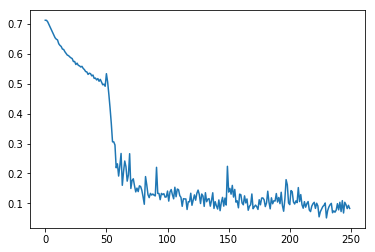

In [14]:
# code here
# Hint: Use matplotlib.pyplot to plot the curve
# write your code here
matplotlib.pyplot.plot(curr_step,step_loss)
plt.show()

*************************************************************************************

### 2.4 模型的评估方式

常用的分割效果评估方式有两种，一种是计算`Jaccard`值，一种是计算`Dice`值。两者比较类似，单调性相同，可以相互转换，但是数值性质有细微的不一样。下面会对此进行简单的回顾和说明。   

值得注意的是（细心的你可能自己已经注意到了），我们在训练神经网络的时候，使用了`Binary Cross Entropy`，而在评估模型好坏的时候，却不是使用每一个像素点的分类的准确度百分比（之前你们使用的`Cross Entropy`训练分类网络的时候，评估模型的结果是时候，使用的是每一类的分类的准确度，而这里，对应的做法应该是计算每一个像素点的分类的准确度），这是为什么呢？ 这种损失函数与评估函数之间的差别，会给我们的训练带来什么不好的影响呢？

#### 2.4.1 Jaccard值的理解
现在你只需要意识到这样的问题存在，然后我们不妨先来回顾下[`Jaccard`](https://zh.wikipedia.org/wiki/%E9%9B%85%E5%8D%A1%E5%B0%94%E6%8C%87%E6%95%B0)值。
>雅卡尔指数（英语：Jaccard index），又称为并交比（Intersection over Union）、雅卡尔相似系数（Jaccard similarity coefficient），是用于比较样本集的相似性与多样性的统计量。雅卡尔系数能够量度有限样本集合的相似度，其定义为两个集合交集大小与并集大小之间的比例：
>$$J(A,B) = {{|A \cap B|}\over{|A \cup B|}} = {{|A \cap B|}\over{|A| + |B| - |A \cap B|}}.$$ 
>如果A与B完全重合，则定义J(A,B) = 1。于是有:
>$$0\le J(A,B)\le 1.$$

直观理解如下两图所示：

![Intersection](resources/1280px-Intersection_of_sets_A_and_B.svg.png)
![Union](resources/1280px-Union_of_sets_A_and_B.svg.png)

*`Jaccard`值等于上子图的紫色部分和下子图的紫色部分的比值。在离散的像素图像中表现为：上下两图的紫色部分的像素点个数的比值（这也是我们在计算的时候使用的方法）。*

#### 2.4.2 `Dice`值的理解

有了上面`Jaccard`值的铺垫，[`Dice`](https://zh.wikipedia.org/wiki/Dice%E7%B3%BB%E6%95%B0)值就非常容易理解了:   
>Dice系数, 根据 Lee Raymond Dice 命名，是一种集合相似度度量函数，通常用于计算两个样本的相似度：
$$s = \frac{2 | X \cap Y |}{| X | + | Y |}$$
它和Sørensen 相似度指数相同, 也称作Sørensen-Dice系数。 它在形式上和Jaccard指数没多大区别，但是有些不同的性质。
和Jaccard类似，它的范围为0到1。   



**********************************************************************************************
#### &#9733;&#9733;&#9733; Question 3：
请结合对`Jaccard`值的理解，根据`Jaccard`值的计算公式，补充好`./unet/dice_loss.py`中`JaccardCoeff`类的内容，使其能够正确计算出预测结果的`Jaccard`值。**然后执行以下代码进行测试和比较，观察你的输出结果是否正确**。   
【tips】参考和借鉴同文件中`DiceCoeff`类的实现方法
【tips】只需要按指示完成`forward`函数即可，不需要写`backward`函数

In [15]:
#from unet import dice_coeff as dice
from unet import JaccardCoeff as jaccard


# get three 2D matrix as inputs
eye   = torch.tensor( np.eye(3)       )
ones  = torch.tensor( np.ones([3, 3]) )
zeros = torch.tensor( np.zeros([3,3]) )

# show the input
print( eye )
print( ones )
print( zeros )

# get your result
print( jaccard().forward(eye,   eye)   )  
print( jaccard().forward(eye,   ones)  )
print( jaccard().forward(zeros, ones)  )
print( jaccard().forward(zeros, zeros) )

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], dtype=torch.float64)
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)
tensor(1.)
tensor(0.3333)
tensor(1.1111e-05)
tensor(1.)


其结果如下图所示：

``` Python  
tensor([[ 1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.]], dtype=torch.float64)
tensor([[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.]], dtype=torch.float64)
tensor([[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], dtype=torch.float64)
tensor(1.0000)
tensor(0.3333)
tensor(1.00000e-05 *
       1.1111)
tensor(1.)
```

【Tips】回顾`Dice`值的计算公式，考虑两张图像中每一个像素点均为0的情况，此时分母为0，计算没有意义。因此，我们需要在计算的时候给分子和分母加上平滑项`eps`，使得计算具有意义，`eps`取极小值，避免对非零值计算的时候产生太大的误差。
*************************************************************************************************

#### 2.4.3 拓展理解——为什么要使用Jaccard和Dice来评估模型

也就是回答上面提到的问题，为什么我们在训练神经网络的时候，使用了`Binary Cross Entropy`，而在评估模型好坏的时候使用Jaccard和Dice值。这个问题的理解我们
在此引用了国外的一篇优秀的博文进行理解，感兴趣的同学可以点击[这里](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)阅读原文。  

【tips】*本问题仅作思考，不作任何要求，不加分，欢迎交流.*

#### Answer

The training process uses `Binary Cross Entropy` method to train the network and use `Jaccard or Dice` similarity comparason to evaluate the model performance. Actually, this seems to be a nature measurement because of the following reason:

- **Binary Cross Entropy**: With sigmoid as the activation function, *BCE* is often chosen as the loss function. **Why?** The nature of the sigmoid function, $\sigma '(z)$ is usually very small for most values of $z$ (the two ends of the graph are almost flat), and this makes $w$ and $b$ very slow to update (because vertical * a * sigma '(z) is close to 0). [Ref.](https://blog.csdn.net/wtq1993/article/details/51741471)
- **Jaccard or Dice as Evaluation**: It's intrinsic for us to consider similarity comparason to evaluate our model, for our goal expects a similar generated image with the origin. **Jaccard** (*as well as Consine, but Jaccard is more accurate for calculating behavioural correlations in CTR manner*) is the widest use of similarity comparason method. **Dice coefficient** is a statistic used to gauge the similarity of two samples. [Ref. 1](https://blog.csdn.net/qq_30911665/article/details/74356112) [Ref. 2](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) 

Thus we take them as our training loss function and evaluate method respectively due to the standardization.

### 2.5 观测和分析实验结果

**********************************************************************************************
#### &#9733;&#9733;&#9733; Question 4
在分割模型中，如何通过卷积神经网络的结果得到预测结果？请阅读和执行以下代码后进行简要的分析。    

【Tips】网络输出的是一个很大数值，然后使用`sigmod`函数可以网络输出归一化为0到1之间的数值，使得各个像素点的概率可比较。语义分割网络输出的`channel`数为前景数目加上背景数目，一般第0个`channel`输出的是每个像素点对应被判别为背景的概率，第1个`channel`输出的每个像素点对应的判别第一类物体的概率。VOC数据集需要对20类物体进行分割，加上背景类，网络输出的`channel`数为21，本次实验中仅对1类物体进行分割，网络输出的`channel`数为2.

【Tips】可以先阅读和执行下面的代码再回来回到这个问题

#### Answer 4

1. Get the prediction output: `masks_pred = unet(batch_x)`;
2. Normalize prediction output as regular output: `masks_probs = F.sigmoid(masks_pred)`;
3. Use regular output to binarize output into mask output: `masks_probs_flat = masks_probs.reshape(-1)`.

***********************************************************************************

根据自己的思考，理解以下代码，并且运行该代码，观察实验结果。

In [16]:
def predict(network, image, grounth_truth ):
    
    # By default all the modules are initialized to 
    # train mode (self.training = True). Also be aware 
    # that some layers have different behavior during training 
    # and evaluation (like BatchNorm, Dropout)
    # so we should change the mode
    network.eval()
    
    # be aware of the B×H×W×C and the B×C×H×W
    image = np.transpose( image, axes=[0, 3, 1, 2] ).astype(np.float32)
    
    # prepare the input datatype
    image_input = torch.from_numpy(image)
    image_input = image_input.cuda() if is_cuda else image_input

    # get the network output, and then regular each pixel between 0 and 1
    masks_pred = network(   image_input )
    masks_prob = F.sigmoid( masks_pred  )
    
    # get numpy object result from torch.tensor
    if is_cuda:
        masks_prob = masks_prob.cpu().data.numpy()
    else:
        masks_prob = masks_prob.data.numpy()
    
    masks_binary = masks_prob.copy()
    
    # if the prossibility is greater than 0.5, we mask it as 1
    # if the prossibility is less then 0.5, we mask it as 0
    masks_binary[ masks_binary>=0.5 ] = 1
    masks_binary[ masks_binary< 0.5 ] = 0
    # predication is finished！
    
    # show me the result
    fig, axs = plt.subplots(2,2, sharey=True, figsize=(10,8))
    axs[0][0].set_title("Original data show in color")
    axs[0][1].set_title("Ground Truth")
    axs[1][0].set_title("Probility heatmap")
    axs[1][1].set_title("Predition")
    
    ax00 = axs[0][0].imshow( image[0,0,...],        aspect="auto" )
    ax01 = axs[0][1].imshow( ground_truth[0,...,1], aspect="auto" )
    ax10 = axs[1][0].imshow( masks_prob[0,1,...],   aspect="auto", cmap="hot" )
    ax11 = axs[1][1].imshow( masks_binary[0,1,...], aspect="auto" )
    
    fig.colorbar(ax00, ax=axs[0][0])
    fig.colorbar(ax01, ax=axs[0][1])
    fig.colorbar(ax10, ax=axs[1][0])
    fig.colorbar(ax11, ax=axs[1][1])
        

有了训练好的模型以及预测函数，我们就可以拿图片生成器来生成一些新的图片进行测试了，请重复多次执行以下框框中的代码，观察不同的图片的预测结果。

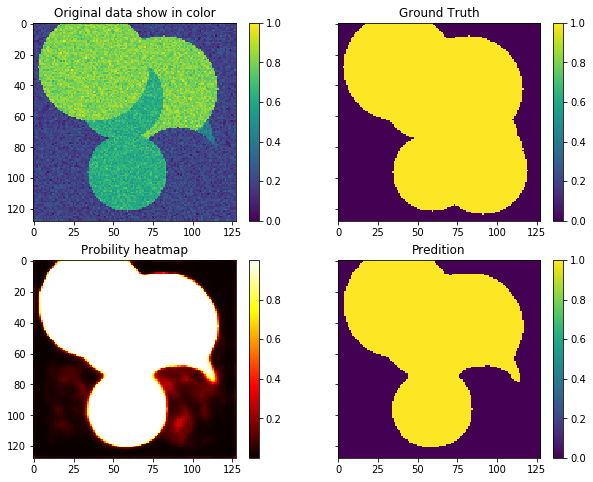

In [17]:
input, ground_truth = generator(1)
predict(unet, input, ground_truth)

*上图中左上角的子图是输入到UNet中的图片；右上角的子图是输入图片的标签，分割的（Ground Truth）；左下角的子图是每个像素点的概率图，颜色越亮，概率越大，这个子图的图片也就是上面的框框第19行的输出值；右下角的子图是网络的预测值，也即是将左下角的子图以0.5为临界值，上下取整后输出的图像。*

********************************************************************************************************
#### &#9733;&#9733;&#9733; Question 5
反复执行上述代码，找出预测结果不好的图片，并且分析为什么该图片的预测结果会比较糟糕？

#### Answer 5

Excerpts of results.

<p align="right"><img src="https://ws1.sinaimg.cn/large/006tNc79ly1g22cyq77frj31400u048d.jpg" alt="ScoreChain" title="ScoreChain" length = "900" width="900"/><br/></p>

When there is few color differences between the background and part of the image, Unet can hardly tell whether it's a part of the picture.

**********************************************************************************************

## 3. 修改网络模型

简单修改网络结构，如修改网络的深度，使得网络更加深或者更加浅，体会网络的深度对分割模型的影响；又比如将__`upsample`__过程中的浅层特征的__`concate`__修改成__`add`__，体会不同操作对实验结果的影响。


### 3.1 降低网络的层数

网络的深度对网络的性能产生着至关重要的影响。一般来说，网络越深，描述能力越强，性能越高。但是，也会带来梯度消失、梯度爆炸等一系列的障碍，使得网络训练更加困难。在本次实验中，是要求大家练习降低网络的层数，目的是让大家更加熟悉UNet的结构。

原始的Unet结构是共有5层（根据上述提供的模型结构从上往下数），downsample操作执行了4次，对应部分的代码位于`./unet/unet_model.py`文件中。现根据已提供的代码，按照以下操作提示，将网络模型层数，使得Unet模型更加浅层，并且对该模型进行训练，观察实验结果，

********************************************************************************************
#### &#9733;&#9733;&#9733; Question 6
1、在__`./unet/unet_model.py`__文件中创建一个新的类，命名为__`UNet_shallow`__,该类只__`downsample`__两次，共三层，请参考`Unet`类的写法   

2、将写好的模型重新进行训练，并观察训练好的实验结果。
****************************************************************************************

以下部分代码与前面部分的代码高度类似，可从上面的函数中直接复制粘贴下执行，获取新的模型的结果。注意，上面几个部分的代码比较松散，中间穿插的内容比较多。在这里的话，但实际上训练模型的代码集中起来就以下几步，可以在这里集中理解一下下。

In [18]:
# the only difference of the three cells with above is the model
from unet import UNet_shallow

In [19]:
unet_shallow = UNet_shallow(n_channels=1, n_classes=2)
criterion = nn.BCELoss()                       
optimizer = optim.SGD( unet_shallow.parameters(),
                       lr           = 0.001,
                       momentum     = 0.9,
                       weight_decay = 0.0005
                     )

if is_cuda:
    unet_shallow = unet_shallow.cuda()

In [20]:
epochs     = 5         # usual value is 50, 100, 150
steps      = 50        # usual value is ？ No usual value, just go through the whole training set
batch_size = 4         # usual value is 16， 32， 64, usually as big as possible
valid_size = 50        # No usual value, just 20% of the whole dataset

epoch_loss = 0

# use to plot the loss during training
curr_step  = np.zeros( epochs*steps )
step_loss  = np.zeros( epochs*steps )
counter    = 0
for epoch in range(epochs):
    for step in range(steps):
        batch_x, batch_y = generator(batch_size)
        
        # Remember the different between B*H*W*C and B*C*H*W 
        batch_x = np.transpose( batch_x, axes=[0, 3, 1, 2] ).astype(np.float32)
        batch_y = np.transpose( batch_y, axes=[0, 3, 1, 2] ).astype(np.float32)
        
        batch_x = torch.from_numpy( batch_x )
        batch_y = torch.from_numpy( batch_y )
        
        if is_cuda:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
        
        masks_pred       = unet_shallow(batch_x)
        masks_probs      = F.sigmoid(masks_pred)
        masks_probs_flat = masks_probs.reshape(-1)

        
        batch_y_flat     = batch_y.reshape(-1)
        loss             = criterion( masks_probs_flat, batch_y_flat)
        
        curr_step[ counter ] = epoch*steps + step
        step_loss[ counter ] = loss.item()
        counter += 1
        
        if (step+1) % 10==0:
            print("epoch {0:} step {1:} loss is {2:0.4f}".format(epoch+1, step+1, loss.item()) )
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    val_score = eval_net( unet_shallow, generator, gpu=is_cuda, num_validation=2 )
    print("validation dice coeff: {}".format( val_score) )

epoch 1 step 10 loss is 0.6275
epoch 1 step 20 loss is 0.5730
epoch 1 step 30 loss is 0.5198
epoch 1 step 40 loss is 0.4894
epoch 1 step 50 loss is 0.4409
validation dice coeff: 0.8383811414241791
epoch 2 step 10 loss is 0.2113
epoch 2 step 20 loss is 0.1370
epoch 2 step 30 loss is 0.1545
epoch 2 step 40 loss is 0.1533
epoch 2 step 50 loss is 0.0840
validation dice coeff: 0.8955733478069305
epoch 3 step 10 loss is 0.2293
epoch 3 step 20 loss is 0.1086
epoch 3 step 30 loss is 0.0583
epoch 3 step 40 loss is 0.1884
epoch 3 step 50 loss is 0.1651
validation dice coeff: 0.9265601634979248
epoch 4 step 10 loss is 0.1990
epoch 4 step 20 loss is 0.1087
epoch 4 step 30 loss is 0.2236
epoch 4 step 40 loss is 0.0902
epoch 4 step 50 loss is 0.2952
validation dice coeff: 0.9093584418296814
epoch 5 step 10 loss is 0.0902
epoch 5 step 20 loss is 0.0781
epoch 5 step 30 loss is 0.1027
epoch 5 step 40 loss is 0.1349
epoch 5 step 50 loss is 0.1804
validation dice coeff: 0.936606764793396


反复执行一下代码，找出训练得不好的图像。（我们人眼是否能够准确得区分出分错图像的边界呢？）

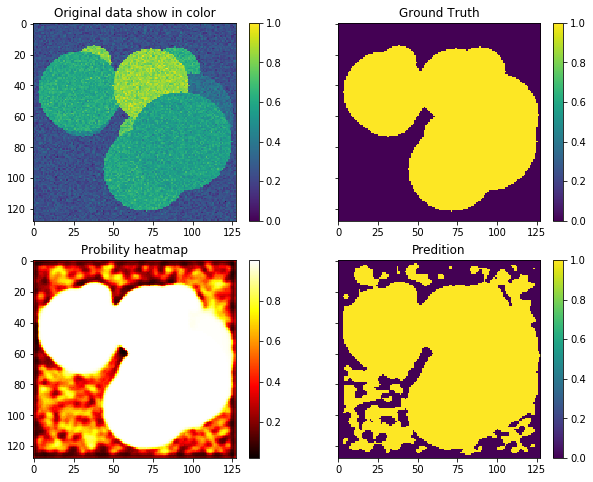

In [21]:
input, ground_truth = generator(1)
predict(unet_shallow, input, ground_truth)

Bad examples are shown as following:

<p align="right"><img src="https://ws3.sinaimg.cn/large/006tNc79ly1g22d5ymm6mj317q0mk790.jpg" alt="ScoreChain" title="ScoreChain" length = "900" width="900"/><br/></p>

Actually it's hard for us to recognize the wrong prediction！

### 3.2 将`concat`操作与`add`操作进行比较

卷积神经网络在进行特征提取的过程中，具有很强的平移不变性，即不管关键特征位于图像的上下左右各种不同位置，卷积神经网络的特征提取部分都能够很好提取出这部分特征。但是这个特点却会使得网络提取出来的特征丧失掉大部分的空间位置特征。平移不变性在分类器的应用中自然是很好的一个特点，但是却不利于语义分割的细节恢复。这是因为在特征提取过程中提取出来的高维特征已经丢失了大部分的位置信息，而语义分割的过程不仅需要去除背景、恢复图像的关键特征，还需要将图像的关键特征在其原本的位置标注出来。

因此，为了恢复图像的位置信息，语义分割模型就需要在图像细节恢复的过程中（`decoder`过程）将低层的特征图与高层的特征图结合起来，为细节恢复的过程提供足够的位置信息。通常，这有两种操作方式，第一种是以FCN为代表的做法，那就是将浅层特征矩阵与高层特征矩阵相加（`add`）；第二种就是类似于`UNet`的做法，浅层的特征矩阵与高层的特征矩阵级联起来（`concate`）。

现在要求你将`UNet`中的`concate`结构修改成`add`的结构，并且将这种新的结构构建一个新的`UNet`命名为`UNet_add`,然后模仿上面的两个网络的训练过程，训练`UNet_add`。（可参考以上的训练的过程）   
    1. 请先在`./unet/unet_part.py`中参考`up`类的代码（使用的是`concat`方法），将`up_add`类补充完整。   
    2. 然后在`./unet/unet_model.py`中将`Unet_add`类的`forward`函数补充完整    
    3. 按照下面的指示（可复制上面提供的代码），完成`Unet_add`这个网络的训练过程     
    
【tips】将`concate`的操作替换成`add`的操作会带来网络传递过程中维度的改变，也就是`decoder`部分。注意体会这部分卷积核参数的变化

In [22]:
# import your Model
from unet import UNet_add

定义新的模型、损失函数和优化函数

In [23]:
# define model criterion and optimizer
unet_add = UNet_add(n_channels=1, n_classes=2)
criterion = nn.BCELoss()                       
optimizer = optim.SGD( unet_add.parameters(),
                       lr           = 0.001,
                       momentum     = 0.9,
                       weight_decay = 0.0005
                     )

if is_cuda:
    unet_add = unet_add.cuda()

训练模型

In [24]:
# you can copy the code ahead, but remember to change the model name
epochs     = 5         # usual value is 50, 100, 150
steps      = 50        # usual value is ？ No usual value, just go through the whole training set
batch_size = 4         # usual value is 16， 32， 64, usually as big as possible
valid_size = 50        # No usual value, just 20% of the whole dataset

epoch_loss = 0

# use to plot the loss during training
curr_step  = np.zeros( epochs*steps )
step_loss  = np.zeros( epochs*steps )
counter    = 0
for epoch in range(epochs):
    for step in range(steps):
        batch_x, batch_y = generator(batch_size)
        
        # Remember the different between B*H*W*C and B*C*H*W 
        batch_x = np.transpose( batch_x, axes=[0, 3, 1, 2] ).astype(np.float32)
        batch_y = np.transpose( batch_y, axes=[0, 3, 1, 2] ).astype(np.float32)
        
        batch_x = torch.from_numpy( batch_x )
        batch_y = torch.from_numpy( batch_y )
        
        if is_cuda:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
        
        masks_pred       = unet_add(batch_x)
        masks_probs      = F.sigmoid(masks_pred)
        masks_probs_flat = masks_probs.reshape(-1)

        
        batch_y_flat     = batch_y.reshape(-1)
        loss             = criterion( masks_probs_flat, batch_y_flat)
        
        curr_step[ counter ] = epoch*steps + step
        step_loss[ counter ] = loss.item()
        counter += 1
        
        if (step+1) % 10==0:
            print("epoch {0:} step {1:} loss is {2:0.4f}".format(epoch+1, step+1, loss.item()) )
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    val_score = eval_net( unet_add, generator, gpu=is_cuda, num_validation=2 )
    print("validation dice coeff: {}".format( val_score) )

epoch 1 step 10 loss is 0.6433
epoch 1 step 20 loss is 0.6039
epoch 1 step 30 loss is 0.5648
epoch 1 step 40 loss is 0.5164
epoch 1 step 50 loss is 0.4637
validation dice coeff: 0.9465128481388092
epoch 2 step 10 loss is 0.4379
epoch 2 step 20 loss is 0.4628
epoch 2 step 30 loss is 0.2396
epoch 2 step 40 loss is 0.1842
epoch 2 step 50 loss is 0.1893
validation dice coeff: 0.9529066383838654
epoch 3 step 10 loss is 0.0881
epoch 3 step 20 loss is 0.1224
epoch 3 step 30 loss is 0.1638
epoch 3 step 40 loss is 0.2974
epoch 3 step 50 loss is 0.5226
validation dice coeff: 0.9588183760643005
epoch 4 step 10 loss is 0.1895
epoch 4 step 20 loss is 0.0789
epoch 4 step 30 loss is 0.1023
epoch 4 step 40 loss is 0.2153
epoch 4 step 50 loss is 0.1919
validation dice coeff: 0.9429665505886078
epoch 5 step 10 loss is 0.1341
epoch 5 step 20 loss is 0.1199
epoch 5 step 30 loss is 0.2107
epoch 5 step 40 loss is 0.0512
epoch 5 step 50 loss is 0.3697
validation dice coeff: 0.9834916591644287


查看训练结果

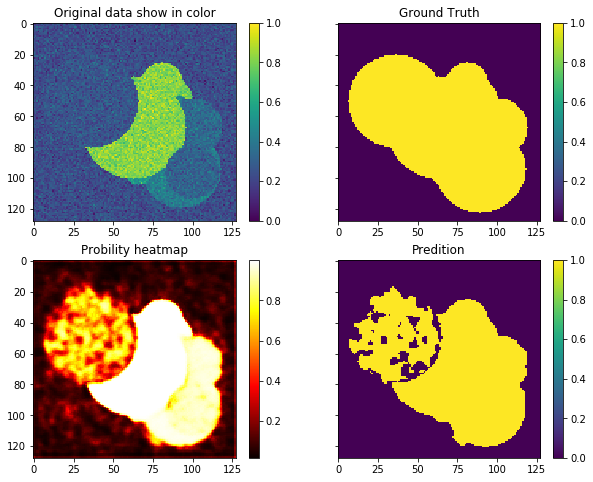

In [25]:
# visiual UNet_add's result
input, ground_truth = generator(1)
predict(unet_add, input, ground_truth)

<p align="right"><img src="https://ws2.sinaimg.cn/large/006tNc79ly1g22da7di07j314s0ku78b.jpg" alt="ScoreChain" title="ScoreChain" length = "900" width="900"/><br/></p>

We see that seldom improvement is developed and it seems the accuracy even drops!

## 附录：利用numpy手动实现反卷积的过程

要了解反卷积的计算过程，我们要先来回顾卷积的实现过程。卷积的运算过程非常的简单，就是卷积核的不断平移和乘加。但是事实上，卷积运算通过卷积核大小的改变、平移的步长、图像边边的补零等一系列的操作，卷积过程的运算种类是非常多的。

各种卷积过程直观显示大礼包[点击这里](https://github.com/vdumoulin/conv_arithmetic)

### 1. 卷积的实现

作为例子，为了便于大家理解（和省事），我们在这里仅仅提供了一种加`Padding`，步长为`1`的卷积过程的实现。这种卷积运算输入的`Feature map`和输出的`Feature map`的大小是一致的。其计算原理如下图所示。代码中所有的实现思路均与该动图一致。

![convolution](resources/conv.gif)

首先，实现一个最基本的最简答的卷积过程，这个卷积运算是单通道输入和单通道输出，用作卷积的最基础的运算模块。该运算过程也就是上图中上下两个分支中的一个分支的运算过程。

In [26]:
def convolution( feature_map, kernel ):   
    # h : height of feature_map
    # w : weight of feature_map
    # k : kernal_size
    h, w = feature_map.shape
    k, _ = kernel.shape
    
    # p : padding size in the feature map
    p = int( k/2 )
    
    
    
    # add zeors padding for the input feature map
    feature_map_padding = np.zeros([ h+p*2, w+p*2 ])
    feature_map_padding[ p:h+p, p:w+p ] = feature_map
    
    result = np.zeros([h, w])
    for i in range(h):
        for j in range(w):
            # region of interest
            roi          = feature_map_padding[i:i+k, j:j+k]
            result[i][j] = np.sum( roi * kernel )
    return result

以上只是最简单版本的单通道输入、单通道输出的卷积过程。然而，我们在实际运算的过程中用到的都是多通道输入、多通道输入的卷积。在上述模块的基础上，我们可以很容易地实现多通道输入多通道输入的卷积运算过程。只需要使用两个`for`循环，遍历每一个通道的输入和每一个通道的输出即可。如下所示。

In [27]:
def conv2d( input, weights ):
    # c : channel
    # h : height
    # w : weight
    in_channel, h, w = input.shape
    out_channel, *_  = weights.shape
    
    output = np.zeros( [out_channel, h, w] )
    for i in range(out_channel):
        weight = weights[i]
        for j in range(in_channel):
            feature_map = input[j]
            kernel      = weight[j]
            output[i]  += convolution(feature_map, kernel)
    return output

写好函数后，我们使用上面动图所显示的矩阵来验证一下程序运算结果的正确性。

In [28]:
import numpy as np
input_data=[
              [[1,0,1,2,1],
               [0,2,1,0,1],
               [1,1,0,2,0],
               [2,2,1,1,0],
               [2,0,1,2,0]],

               [[2,0,2,1,1],
                [0,1,0,0,2],
                [1,0,0,2,1],
                [1,1,2,1,0],
                [1,0,1,1,1]],
 
            ]
weights_data=[[ 
               [[ 1, 0, 1],
                [-1, 1, 0],
                [ 0,-1, 0]],
    
               [[-1, 0, 1],
                [ 0, 0, 1],
                [ 1, 1, 1]] 
           ]]

# change list into numpy array
input   = np.array( input_data  )
weights = np.array( weights_data )

# show the result
print( conv2d(input, weights) )

[[[ 2.  0.  2.  4.  0.]
  [ 1.  4.  4.  3.  5.]
  [ 4.  3.  5.  9. -1.]
  [ 3.  4.  6.  2.  1.]
  [ 5.  3.  5.  1. -2.]]]


那么在`Pytorch`中是否也是这样子实现的呢？我不得而知，其实现计算原理是一致的，但是实现起来的输入输出的控制，低层硬件的优化会很复杂。使用`Pytorch`代码验证一下以上数值计算结果会比较复杂，需要将单个的卷积操作当做一个极小的网络，然后进行运算，其代码如下所示（不作理解要求）。

In [29]:
input         = torch.tensor(input_data).unsqueeze(0).float()

torch_conv2d  = torch.nn.Conv2d(in_channels=2, out_channels=1, \
                                kernel_size=3, padding = 1)

state = torch_conv2d.state_dict()
state["weight"] = torch.tensor(weights_data).float()
state["bias"]   = torch.zeros(torch.Size([1]) )
torch_conv2d.load_state_dict(state)
print(torch_conv2d(input))

tensor([[[[ 2.,  0.,  2.,  4.,  0.],
          [ 1.,  4.,  4.,  3.,  5.],
          [ 4.,  3.,  5.,  9., -1.],
          [ 3.,  4.,  6.,  2.,  1.],
          [ 5.,  3.,  5.,  1., -2.]]]], grad_fn=<MkldnnConvolutionBackward>)


### 2. 反卷积的实现

在深度学习上，细节的恢复本来是依靠简单的`Upsample`，为了使得细节恢复更加温和，就使用反卷积这种操作。这种操作具体来说指的是如下图所示的一个操作，即：先对输入的矩阵进行插空补零，然后在进行简单的普通的卷积操作，使得输出的矩阵比输入的矩阵更大。**一句话来说就是，卷积的过程使得输出的`Feature map`比输入的`Feature map`在尺寸上更小，在特征表示上更加抽象；而反卷积的过程则是使得输出的`Feature map`比输入的`Feature map`在尺寸上更大，细节更加丰富，特征表示上更加具象，两者的参数均可训练。**详细的介绍可参考这篇文章（点击[这里](https://arxiv.org/pdf/1603.07285.pdf)）,这篇文章总结得很全。

而在反卷积的名字之争的话，则要另开一话了。感兴趣的可以点击[这里](https://www.zhihu.com/question/43609045)阅读原文
>逆卷积相对于卷积在神经网络结构的正向和反向传播中做相反的运算。逆卷积(Deconvolution)比较容易引起误会，转置卷积(Transposed Convolution)是一个更为合适的叫法. 


>Deconv本身其实有标准定义指conv的逆运算，一般通过Fourier Transform求解。深度学习里的deconv其实用错了，不是指逆运算，而是指transposed convolution, backward convolution, fractally strided convolution, upsampling convolution.

在实现上，反卷积操作思路如下：先对输入的矩阵填充0，然后进行卷积，卷积过程跟上述的加Padding的卷积过程一致，最后进行裁剪，使得输出的图像大小是输入的两倍。注意观察，填充0的操作会使得经过卷积之后，原来input的数值在output中不发生改变（红色数字）。如下图所示：

![deconv](resources/deconvolution.PNG)

根据上述思路，反卷积的实现过程主要分为一下两个函数，一个是补零，一个是反卷积，实现起来非常简单。

In [30]:
def fill_zeros(input):
    # c : channel
    # h : height
    # w : weight
    c, h, w  = input.shape
    result   = np.zeros( [c, h*2+1, w*2+1] )

    for i in range(c):
        for j in range(h):
            for k in range(w): 
                result[ i, 2*j+1, 2*k+1 ] = input[i, j, k] 
    return result


***********************************************************************************
#### &#9733;&#9733;&#9733; Question 7
请根据你的理解，完成一下反卷积函数，并在接下来的程序中，验证函数实现的正确性。
******************************************************************************

In [31]:
#
def deconv2d( input, weights ):
    # input.shape is ( channel, height, weight )
    _, input_h, input_w = input.shape
    out_h = input_h*2
    out_w = input_w*2
    
    ############################################################
    # write your code here
    # fill zeros
    fz_input = fill_zeros(input)
    
    # conv2d 
    result = conv2d(fz_input, weights)
    
    # cut the padding
    result = result[:,1:result.shape[1]-1,1:result.shape[2]-1]
    
    #############################################################

    return result

设置的输入函数如下所示：

In [32]:
input_data=[
               [[1,0,1],
                [0,2,1],
                [1,1,0]],

               [[2,0,2],
                [0,1,0],
                [1,0,0]],

               [[1,1,1],
                [2,2,0],
                [1,1,1]],

               [[1,1,2],
                [1,0,1],
                [0,2,2]]

            ]

weights_data=[ 
              [[[ 1, 0, 1],
                [-1, 1, 0],
                [ 0,-1, 0]],
               [[-1, 0, 1],
                [ 0, 0, 1],
                [ 1, 1, 1]],
               [[ 0, 1, 1],
                [ 2, 0, 1],
                [ 1, 2, 1]], 
               [[ 1, 1, 1],
                [ 0, 2, 1],
                [ 1, 0, 1]]],
    
              [[[ 1, 0, 2],
                [-2, 1, 1],
                [ 1,-1, 0]],
               [[-1, 0, 1],
                [-1, 2, 1],
                [ 1, 1, 1]],
               [[ 0, 0, 0],
                [ 2, 2, 1],
                [ 1,-1, 1]], 
               [[ 2, 1, 1],
                [ 0,-1, 1],
                [ 1, 1, 1]]]  
           ]

请执行一下代码，查看的你反卷积函数输出。

In [33]:
input   = np.array( input_data  )
weights = np.array( weights_data )
print( deconv2d(input, weights) )

[[[  3.   3.   2.   7.   5.]
  [  6.   8.   5.  11.   2.]
  [  2.   7.   2.   3.   3.]
  [  5.  11.   3.   9.   3.]
  [  1.   4.   5.   4.   4.]]

 [[  6.   0.   1.   8.   5.]
  [  0.   8.  -2.  14.   2.]
  [  3.   9.   8.   1.   0.]
  [  0.  13.   0.  11.   2.]
  [  5.   3.   1.   3.   0.]]]


以下代码作为验证程序正确性使用，不作理解要求。其实现思路同上，即将`Pytorch`中的一个的反卷积操作当做一个迷你的网络来使用即可。

请使用一下Pytorch反卷积代码验证你的结果。

In [34]:
input         = torch.tensor(input_data).unsqueeze(0).float()

torch_deconv2d  = torch.nn.ConvTranspose2d( in_channels=4, \
            out_channels=2, kernel_size=3, padding = 1, stride=2)

state = torch_deconv2d.state_dict()
weights = np.rot90(np.array(weights_data), 2, axes=(2,3)).copy()

#weights = np.array(weights_data)
state["weight"] = torch.from_numpy(weights).float().transpose(1, 0)
state["bias"]   = torch.zeros(torch.Size([2]))
torch_deconv2d.load_state_dict(state)
print(torch_deconv2d(input))

tensor([[[[ 3.,  3.,  2.,  7.,  5.],
          [ 6.,  8.,  5., 11.,  2.],
          [ 2.,  7.,  2.,  3.,  3.],
          [ 5., 11.,  3.,  9.,  3.],
          [ 1.,  4.,  5.,  4.,  4.]],

         [[ 6.,  0.,  1.,  8.,  5.],
          [ 0.,  8., -2., 14.,  2.],
          [ 3.,  9.,  8.,  1.,  0.],
          [ 0., 13.,  0., 11.,  2.],
          [ 5.,  3.,  1.,  3.,  0.]]]], grad_fn=<ThnnConvTranspose2DBackward>)
